# Secondary Exploration

After an initial exploration of the dataset it was clear than some cleaning needed to take place. Now we re-examine the data after cleaning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append("..")
from car_purchase_help.data_processing import format_raw_df, remove_outliers

%reload_ext autoreload
%autoreload 2
%matplotlib inline
pd.options.display.float_format = '{:20,.2f}'.format
plt.style.use('fivethirtyeight')

In [2]:
colors = {'new': 'green', 'like new': 'blue', 'excellent': 'orange', 'good': 'yellow', 'fair': 'red', 'salvage': 'black'}
def plot_odo_price(manufacturer, model, year):
    manu = df[df['manufacturer'] == manufacturer]
    mod = manu[manu['model'] == model]
    modyear = mod[mod['year'] == year].copy()
    modyear.dropna(subset=['condition'], inplace=True)
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(f'{manufacturer}, {model} from {year}')
    ax.set_xlabel("Miles on the clock")
    ax.set_ylabel("Price")
    l = []
    c = []
    for cond in modyear.condition.unique():
        modyearcond = modyear[modyear['condition'] == cond]
        l.append(ax.scatter(x=modyearcond['odometer'], y=modyearcond['price'], c=colors[cond]))
        c.append(cond)
    ax.legend(l, c)
    plt.show()
    
def plot_year_price(manufacturer, model):
    manu = df[df['manufacturer'] == manufacturer]
    mod = manu[manu['model'] == model].copy()
    mod.dropna(subset=['condition'], inplace=True)
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(f'{manufacturer}, {model}')
    ax.set_xlabel("Year")
    ax.set_ylabel("Price")
    l = []
    c = []
    for cond in mod.condition.unique():
        modcond = mod[mod['condition'] == cond]
        l.append(ax.scatter(x=modcond['year'], y=modcond['price'], c=colors[cond]))
        c.append(cond)
    ax.legend(l, c)
    plt.show()

In [3]:
# https://www.kaggle.com/austinreese/craigslist-carstrucks-data/
df = pd.read_csv(Path('../data/vehicles.csv'))
df = format_raw_df(df)

In [4]:
df.describe()

,price,year,odometer,lat,long
count,"384,319.00","384,319.00","384,319.00","384,319.00","384,319.00"
mean,"161,264.67","2,010.94","101,250.14",38.38,-93.25
std,"20,730,985.57",5.74,"58,198.87",6.79,19.55
min,500.00,"1,981.00","1,001.00",-84.91,-170.29
25%,"6,495.00","2,007.00","52,800.00",34.35,-107.88
50%,"11,999.00","2,012.00","97,804.00",39.30,-87.73
75%,"19,900.00","2,015.00","140,613.50",42.52,-80.84
max,"4,198,286,601.00","2,019.00","299,999.00",84.51,161.02


We see more reasonable statistics in the numerical columns now except for price. It is difficult to put an exact limit on the maximum price. Instead, outliers will be removed once we have restricted the data to a specific make, model and year. Then values can be removed according to the IQR range rule.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384319 entries, 7088746062 to 7082122917
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   url           384319 non-null  object 
 1   region        384319 non-null  object 
 2   region_url    384319 non-null  object 
 3   price         384319 non-null  int64  
 4   year          384319 non-null  int64  
 5   manufacturer  373460 non-null  object 
 6   model         381098 non-null  object 
 7   condition     237995 non-null  object 
 8   cylinders     250382 non-null  object 
 9   fuel          381727 non-null  object 
 10  odometer      384319 non-null  int64  
 11  title_status  382195 non-null  object 
 12  transmission  381181 non-null  object 
 13  vin           263429 non-null  object 
 14  drive         304677 non-null  object 
 15  size          128768 non-null  object 
 16  type          314269 non-null  object 
 17  paint_color   291378 non-null  obje

We will produce some of the same plots from the intial exploration to check that in removing outliers we have not unduly influenced the distribution of the data.

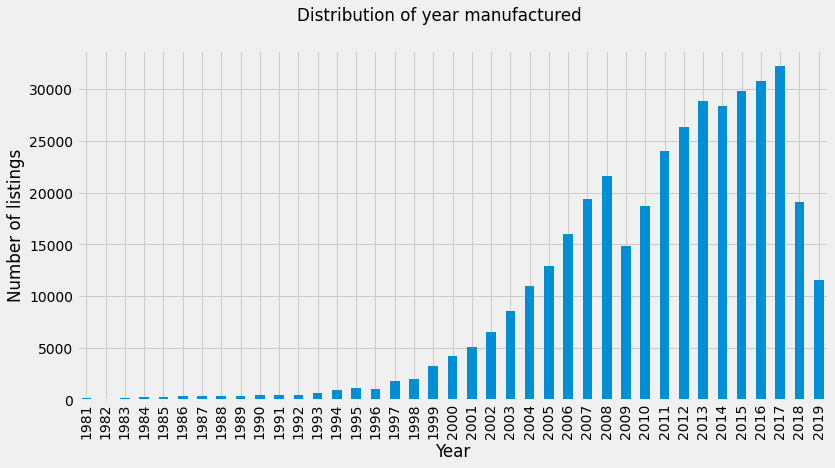

In [6]:
fig = plt.figure(figsize=(12,6))
fig.suptitle("Distribution of year manufactured")
plt.xlabel("Year")
plt.ylabel("Number of listings")
df[df['year'] > 1980]['year'].value_counts().sort_index().plot.bar()

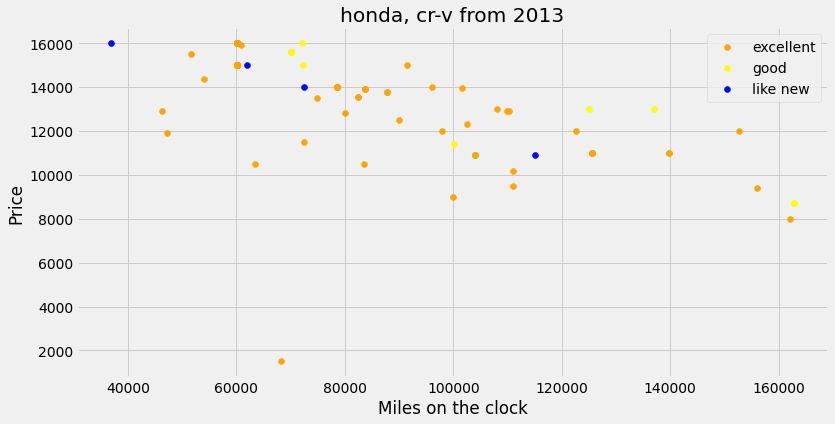

In [7]:
plot_odo_price('honda', 'cr-v', 2013)

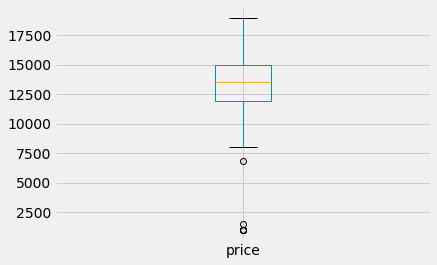

In [8]:
honda = df[df['manufacturer'] == 'honda']
honda_crv = honda[honda['model'] == 'cr-v']
honda_crv_2013 = honda_crv[honda_crv['year'] == 2013]
honda_crv_2013.boxplot(column='price')

This box plot shows that as expected there appear to be outliers in the price column when plotting the price of Honda, CR-Vs from 2013. This shows we should be sure to remove outliers when predicting price.

In [9]:
honda_crv_2013_no_outliers = honda_crv_2013[((honda_crv_2013['price'] - honda_crv_2013['price'].mean()) / honda_crv_2013['price'].std()).abs() < 3]

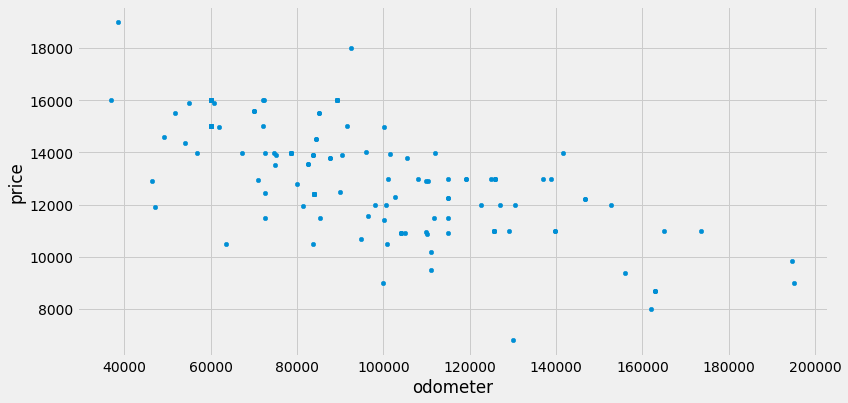

In [10]:
honda_crv_2013_no_outliers.plot.scatter(x='odometer', y='price', figsize=(12,6))

This plot without outliers looks much better than the one above.

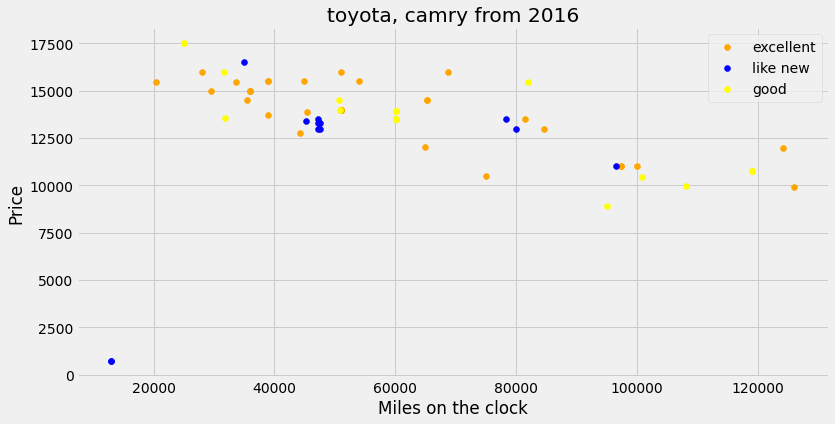

In [11]:
plot_odo_price('toyota', 'camry', 2016)

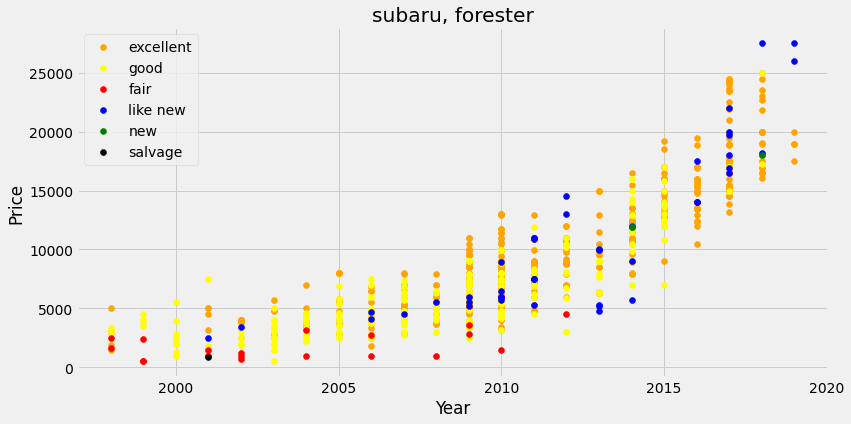

In [12]:
plot_year_price('subaru', 'forester')

In [13]:
subaru_foresters = df[(df['manufacturer'] == 'subaru') & (df['model'] == 'forester')]

In [14]:
subaru_foresters.describe()

,price,year,odometer,lat,long
count,"1,440.00","1,440.00","1,440.00","1,440.00","1,440.00"
mean,"10,391.18","2,011.20","109,645.07",40.07,-91.71
std,"6,108.79",4.77,"54,663.72",6.40,20.49
min,500.00,"1,998.00","1,090.00",-1.00,-157.80
25%,"5,900.00","2,009.00","69,793.00",36.87,-106.29
50%,"8,950.00","2,011.00","108,138.00",40.80,-85.66
75%,"14,814.75","2,015.00","143,504.25",43.08,-76.60
max,"34,194.00","2,019.00","298,843.00",61.52,-1.00


In [15]:
subaru_foresters.sort_values(by='price')

,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,...,vin,drive,size,type,paint_color,image_url,description,state,lat,long
id,,,,,,,,,,,,,,,,,,,,,
7092967345,https://chillicothe.craigslist.org/cto/d/bainb...,chillicothe,https://chillicothe.craigslist.org,500,1999,subaru,forester,fair,4 cylinders,gas,...,JF1SF6359XG749601,NaN,NaN,NaN,silver,https://images.craigslist.org/00L0L_gJRdEN3F7u...,"1999 Subaru Forester. Silver. Over 200,000 mil...",oh,39.21,-83.28
7093382177,https://minneapolis.craigslist.org/ram/cto/d/s...,minneapolis / st paul,https://minneapolis.craigslist.org,500,1999,subaru,forester,fair,4 cylinders,gas,...,NaN,4wd,full-size,NaN,green,https://images.craigslist.org/00T0T_iIeoCInHC2...,"It’s not the prettiest thing, but it runs. I j...",mn,45.07,-93.14
7092950368,https://tampa.craigslist.org/hil/ctd/d/tampa-2...,tampa bay area,https://tampa.craigslist.org,500,2003,subaru,forester,good,4 cylinders,gas,...,NaN,4wd,mid-size,hatchback,green,https://images.craigslist.org/00v0v_9HWIGWVFNp...,500 Down 80 a week You will be done paying in ...,fl,27.99,-82.51
7093317165,https://bellingham.craigslist.org/cto/d/bellin...,bellingham,https://bellingham.craigslist.org,600,1999,subaru,forester,NaN,4 cylinders,gas,...,NaN,4wd,NaN,NaN,red,https://images.craigslist.org/00Q0Q_8b4q0ngHy7...,So unfortunately I've come to the end of the r...,wa,48.71,-122.48
7086055558,https://harrisburg.craigslist.org/cto/d/herndo...,harrisburg,https://harrisburg.craigslist.org,700,2002,subaru,forester,fair,6 cylinders,gas,...,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00u0u_frMkl8hwAw...,"Car runs great, does have a slight oil leak an...",pa,40.69,-76.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7091099338,https://boise.craigslist.org/ctd/d/boise-2019-...,boise,https://boise.craigslist.org,30999,2019,subaru,forester,NaN,4 cylinders,gas,...,JF2SKAWCXKH448357,4wd,NaN,SUV,grey,https://images.craigslist.org/00U0U_lyK5SuuOVr...,"2019 Subaru Forester Touring -- $30,999 ☎ C...",id,43.61,-116.29
7075113555,https://kalispell.craigslist.org/ctd/d/columbi...,kalispell,https://kalispell.craigslist.org,31249,2019,subaru,forester,NaN,NaN,gas,...,JF2SKAUC1KH416786,NaN,NaN,NaN,blue,https://images.craigslist.org/00S0S_985U3PnDXq...,Don K Whitefish address: 6219 Highway 93 So...,mt,48.39,-114.33
7079846737,https://olympic.craigslist.org/ctd/d/puyallup-...,olympic peninsula,https://olympic.craigslist.org,32999,2018,subaru,forester,NaN,4 cylinders,gas,...,JF2SJGWC2JH564933,4wd,NaN,SUV,custom,https://images.craigslist.org/00T0T_7c453QEtTw...,Joydrive: 253-201-0804 https://joydrive.com/...,wa,47.20,-122.31


Initially it was thought that the vehicles being sold for such a low value would just be for salvage although this is not the case. They are old vehicles with many miles on the clock so these price values may be realistic.

## Conclusions

There are still clear outliers in the data in the price column. These will be removed at training time of the model.